# Case study: fixed link transmitter and RAS

## License

```
HOWTO: Calculate level of interference in radio-astronomical
observations produced from a fixed link.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from pycraf import conversions as cnv
from pycraf import pathprof, protection, antenna, geometry

## System parameters

Before we calculate the path attenuation by the terrain around the radio telescope, we first need to determine the level of power that leaks into the RAS bands. Since the fixed-link (FL) service has its own allocations, the primary emission is completely legal. However, RAS observations in adjacent bands (allocated to RAS) could still see spectral side-lobe emission. Usually, this is suppressed with bandpass filters, but if the primary emission is to intense, and/or the bandpass attenuation is not large enough, the unwanted emission could exceed the RA.769 thresholds.

In [2]:
# FL transmitter; 
freq_fl = 10 * u.GHz
bandwidth_fl = 200 * u.MHz
tx_power = 10 * u.mW  # (over the used bandwidth)
suppression = -60 * cnv.dBc

# infer spectral power levels
tx_spectral_power = tx_power / bandwidth_fl
tx_oob_spectral_power = tx_spectral_power.to(cnv.dBm_MHz) + suppression

print('total power, in FL band: {:.1f}'.format(tx_power.to(cnv.dBm)))
print('spectral power, in FL band: {:.1f}'.format(tx_spectral_power.to(cnv.dBm_MHz)))
print('spectral power, out of FL band: {:.1f}'.format(tx_oob_spectral_power.to(cnv.dBm_MHz)))

total power, in FL band: 10.0 dB(mW)
spectral power, in FL band: -13.0 dB(mW / MHz)
spectral power, out of FL band: -73.0 dB(mW / MHz)


In [3]:
# RAS receiver
freq_ras = 10.65 * u.GHz
bandwidth_ras = 100 * u.MHz

# Calculate total power leaking into RAS band:
tx_power_ras_band = tx_oob_spectral_power.to(u.W / u.MHz) * bandwidth_ras
print('total power, in RAS band: {:.1f} = {:.1f}'.format(
    tx_power_ras_band.to(cnv.dBm), tx_power_ras_band.to(cnv.dB_W),
    ))

total power, in RAS band: -53.0 dB(mW) = -83.0 dB(W)


Here we have used the 10.65 GHz RAS allocation (bandwidth: 100 MHz), employing continuum thresholds. Whether continuum or spectral-line thresholds are appropriate is different for each case study and depends (of course) on the type of RAS observations, but also on the type of emission. In many cases, an observatory uses both types of observation. It is also worth noticing, that for real system the spectral mask of the transmitter is usually more complicated. One often makes a distinction between the out-of-band and spurious domain, the former being very close in frequency to the carrier frequency. Furthermore, the spectral response in the three domains is not completely flat. If a well-defined spectrum mask is provided, it is still just a matter of integrating the resulting (frequency-dependent) spectral power over the RAS bandwidth. Be sure, to do the integration in the linear domain, though, and not on the dB-scale!


Note, that the RAS protection thresholds, as defined in ITU-R Rec. RA.769-2 are also provided by pycraf:

In [4]:
protection.ra769_limits()[7:13]

frequency,bandwidth,T_A,T_rx,T_rms,P_rms_nu,Plim,Plim_nu,Slim,Slim_nu,Efield,Efield_norm
MHz,MHz,K,K,mK,dB(W / Hz),dB(W),dB(W / Hz),dB(W / m2),dB(W / (Hz m2)),dB(uV2 / m2),dB(uV2 / m2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1414,27,12,10,0.095,-268.8,-204.5,-278.8,-180.1,-254.4,-34.3,-48.6
1665,10,12,10,0.156,-266.7,-206.7,-276.7,-180.8,-250.8,-35.0,-45.0
2695,10,12,10,0.156,-266.7,-206.7,-276.7,-176.6,-246.6,-30.9,-40.9
4995,10,12,10,0.156,-266.7,-206.7,-276.7,-171.3,-241.3,-25.5,-35.5
10650,100,12,10,0.049,-271.7,-201.7,-281.7,-159.7,-239.7,-13.9,-33.9
15375,50,15,15,0.095,-268.8,-201.8,-278.8,-156.6,-233.6,-10.9,-27.9


In [5]:
ras_power_lim = protection.ra769_limits()[11]['Plim'] * cnv.dB_W
print('RA.769 threshold: {:.1f}'.format(ras_power_lim))

RA.769 threshold: -201.7 dB(W)


Based on these numbers, one defines the *minimal coupling loss* (MCL), which is the minimal path attenuation (accounting for antenna gains) that is necessary to ensure the leaked power to be below the RA.769 levels.

In [6]:
MCL = (tx_power_ras_band.to_value(cnv.dB_W) - ras_power_lim.to_value(cnv.dB_W)) * cnv.dB
print('MCL: {:.1f}'.format(MCL))

MCL: 118.7 dB


## Calculating the path attenuation

Calculating the path propagation loss is really simple with pycraf. A bit more complicated will be to account for the antenna gains.

For Earth-based services, one often assumes the receiver gain to be 0 dBi (i.e., isotropic receiver antenna). The telescope usually won't point towards the FL transmitter, being located at very low elevation, such that the radiation will enter through the side-lobe pattern of the RAS antenna. Of course, one could use a proper description of the RAS antenna pattern, but the astronomical observations are done on quasi-random locations of the sky, so that on average the mean antenna gain, i.e., 0 dBi, will be relevant.

The transmitter gain is of course known, but this is the maximum gain in the direction to the FL receiver. We have to use the FL antenna pattern and figure out how large the effective gain in the direction of the propagation path is.

In [7]:
lon_rt, lat_rt = 6.8836 * u.deg, 50.525 * u.deg  # 100-m Effelsberg radio telescope
lon_fl_tx, lat_fl_tx = 6.938 * u.deg, 50.494 * u.deg
lon_fl_rx, lat_fl_rx = 6.925 * u.deg, 50.528 * u.deg
hprof_step = 100 * u.m  # if made large, Gaussian smoothing is applied to avoid aliasing

Plotting this, to get an idea of the environment:

In [8]:
map_size_lon, map_size_lat = 0.25 * u.deg, 0.25 * u.deg
map_resolution = 3. * u.arcsec

In [9]:
lons, lats, heightmap = pathprof.srtm_height_map(
    lon_rt, lat_rt,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    )


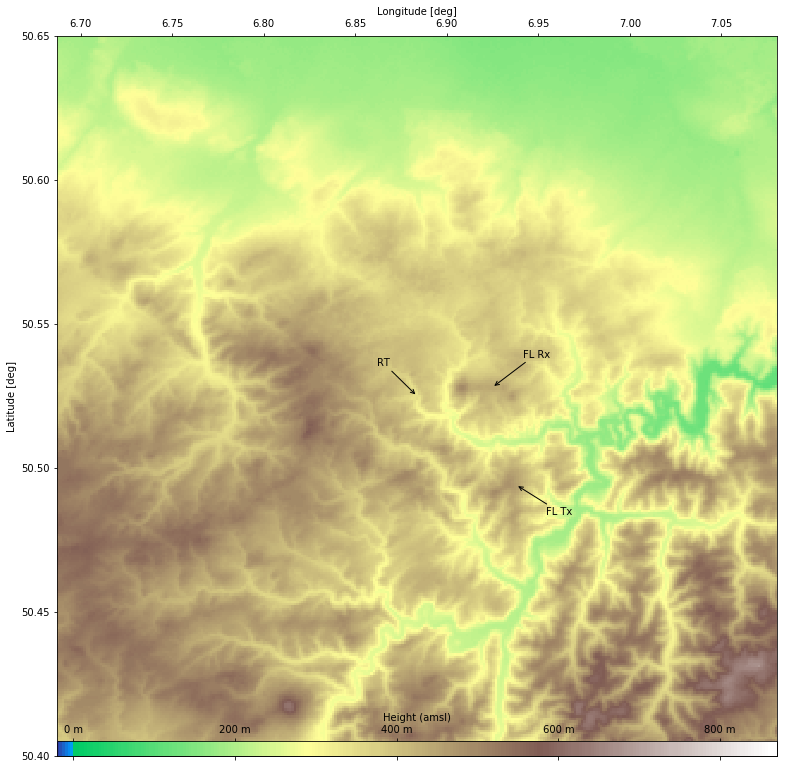

In [10]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_heightmap = heightmap.to(u.m).value

vmin, vmax = -20, 870
terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(sealevel=0.5, vmax=vmax)

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 1150, 200)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.annotate(
    'RT', xy=(lon_rt.value, lat_rt.value), xytext=(-40, 30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )
ax.annotate(
    'FL Tx', xy=(lon_fl_tx.value, lat_fl_tx.value), xytext=(30, -30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )
ax.annotate(
    'FL Rx', xy=(lon_fl_rx.value, lat_fl_rx.value), xytext=(30, 30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )

plt.show()

The next step is to define the other parameters and create the path geometry objects:

In [11]:
# Create PathProp object
temperature = 290. * u.K
pressure = 1013. * u.hPa
time_percent = 2 * u.percent  # see P.452 for explanation

# for the FL terminals, we assume a height of 30-m;
# the RAS antenna has 50-m (elevation axis)
h_fl_tx, h_fl_rx, h_rt = 30 * u.m, 30 * u.m, 50 * u.m

# since all terminals are at large height, we can forget
# about clutter zones; set to UNKNOWN
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN

# we need two PathProp objects, one for the FL link and
# one for the path between FL Tx and RAS Rx
pprop_fl = pathprof.PathProp(
    freq_fl,
    temperature, pressure,
    lon_fl_tx, lat_fl_tx,
    lon_fl_rx, lat_fl_rx,
    h_fl_tx, h_fl_rx,
    hprof_step,
    time_percent,
    zone_t=zone_t, zone_r=zone_r,
    )

pprop_fl_ras = pathprof.PathProp(
    freq_ras,
    temperature, pressure,
    lon_fl_tx, lat_fl_tx,
    lon_rt, lat_rt,
    h_fl_tx, h_rt,
    hprof_step,
    time_percent,
    zone_t=zone_t, zone_r=zone_r,
    )

With the PathProp objects, we can derive the Gain of the transmitter towards the RAS station. For this, we need to work with the bearings and (horizon) elevation angles:

In [12]:
print('FL-FL,  Az/El: {:.1f}, {:.1f}'.format(
    pprop_fl.alpha_tr, pprop_fl.eps_pt
    ))
print('FL-RAS, Az/El: {:.1f}, {:.1f}'.format(
    pprop_fl_ras.alpha_tr, pprop_fl_ras.eps_pt
    ))

FL-FL,  Az/El: -13.7 deg, -0.3 deg
FL-RAS, Az/El: -48.2 deg, -1.1 deg


In [13]:
ang_dist = geometry.true_angular_distance(
    pprop_fl.alpha_tr, pprop_fl.eps_pt,
    pprop_fl_ras.alpha_tr, pprop_fl_ras.eps_pt,
    )
print('Angular distance: {:.1f}'.format(ang_dist))

Angular distance: 34.5 deg


Note, that it was important for this, that the FL transmitter was the origin of the path in both cases. Luckily, the FL antenna pattern to be used for such cases is radial symmetric, such that we only need the angular distance between the two paths (as seen from the FL Tx).

For the FL antenna pattern, we have to assume a certain antenna size:

In [14]:
diameter_fl = 2 * u.m
wavelen_fl = freq_fl.to(u.m, equivalencies=u.spectral())

G_max_fl = antenna.fl_G_max_from_size(diameter_fl, wavelen_fl)
print('FL max. gain: {:.1f}'.format(G_max_fl))

FL max. gain: 44.2 dB


In [15]:
G_eff = antenna.fl_pattern(ang_dist, diameter_fl, wavelen_fl, G_max_fl)
print('Effective gain towards RAS station: {:.1f}'.format(G_eff))

Effective gain towards RAS station: -4.7 dB


We now have all ingredients to compute the final path attenuation:

In [16]:
tot_loss = pathprof.loss_complete(pprop_fl_ras, G_eff, 0 * cnv.dBi)
(L_bfsg, L_bd, L_bs, L_ba, L_b, L_b_corr, L) = tot_loss
print('L_bfsg:   {0.value:5.2f} {0.unit} - Free-space loss'.format(L_bfsg))
print('L_bd:     {0.value:5.2f} {0.unit} - Basic transmission loss associated with diffraction'.format(L_bd))
print('L_bs:     {0.value:5.2f} {0.unit} - Tropospheric scatter loss'.format(L_bs))
print('L_ba:     {0.value:5.2f} {0.unit} - Ducting/layer reflection loss'.format(L_ba))
print('L_b:      {0.value:5.2f} {0.unit} - Complete path propagation loss'.format(L_b))
print('L_b_corr: {0.value:5.2f} {0.unit} - As L_b but with clutter correction'.format(L_b_corr))
print('L:        {0.value:5.2f} {0.unit} - As L_b_corr but with gain correction'.format(L))


L_bfsg:   127.41 dB - Free-space loss
L_bd:     125.94 dB - Basic transmission loss associated with diffraction
L_bs:     167.28 dB - Tropospheric scatter loss
L_ba:     156.52 dB - Ducting/layer reflection loss
L_b:      125.94 dB - Complete path propagation loss
L_b_corr: 125.94 dB - As L_b but with clutter correction
L:        130.63 dB - As L_b_corr but with gain correction


The MCL is smaller than the final path attenuation, which means that the FL link would not exceed the permitted power thresholds at the RAS station. One often defines the *margin*, which is defined as the difference between MCL and path loss:

In [17]:
margin = L - MCL
print('Margin: {:.1f}'.format(margin))

Margin: 12.0 dB


If the margin is positive, compatibility is ensured. A negative value also indicates, by how much the permitted power levels would be exceeded. In such cases, introducing better bandpass filters could improve the situation. Likewise, increasing the distance or bearing angle between FL transmitter and RAS station can help. 